In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
sns.set()
np.random.seed(0)

class MultivariateNormal:
    def __init__(self, mean, cov) -> None:
        self.mean = np.atleast_2d(mean)
        self.cov = np.atleast_3d(cov)
        self.num_of_classes = len(self.mean)

    def create_samples(self, size):
        samples = []
        for i in range(len(self.mean)):
            class_samples = np.random.multivariate_normal(self.mean[i], self.cov[i], size=size)
            samples.append(class_samples)
        return samples


In [2]:
class Parzen:
    def __init__(self, samples, kernel, h) -> None:
        self.samples = samples
        self.kernel = kernel
        self.h = h
        self.d =  np.atleast_2d(samples).shape[1]

    def estimated_pdf(self, x):
        pdf = 0
        for sample in self.samples:
            pdf +=  self.kernel((x - sample)/self.h)

        return pdf / (np.power(self.h, self.d) * len(self.samples))

In [3]:
class SphericalGaussian:
    def __init__(self) -> None:
        pass

    def pdf(self, x):
        x = np.atleast_2d(x)
        d = x.shape[1]
        return np.exp((-0.5) * np.matmul(x, x.T)).diagonal() / np.power(2 * np.pi, d / 2)

In [4]:
class BayesClassifier:
    def __init__(self, likelihoods, priors) -> None:
        self.likelihoods = np.array(likelihoods)
        self.priors = np.array(priors)

    def predict(self, x):
        posteriors = np.array([ll(x) for ll in self.likelihoods]).T * self.priors
        return np.argmax(posteriors, axis=1)

In [5]:
def plot_samples(samples, alpha=1):
    markers = ['o', '^', 's']
    colors = ['green', 'red', 'blue']
    for i in range(len(samples)):
        plt.scatter(samples[i][:, 0], samples[i][:, 1], marker=markers[i], color=colors[i], label='$\omega_{}$'.format(i), alpha=alpha)

    plt.legend(loc='upper left')
    plt.ylabel('$x_2$', size=20)
    plt.xlabel('$x_1$', size=20)
    plt.title(f'Training Data ($ n(\omega_i) = {len(samples[0])}$)', fontsize=20)


In [6]:
means = np.array([[0, 0], [-2, -2], [2, 2]])
cov = np.array([[1, 0],[0, 1]])

np.random.seed(40)

true_distribution = MultivariateNormal(means, np.repeat(cov[np.newaxis, ...], 3, axis=0))

## $n = 50$

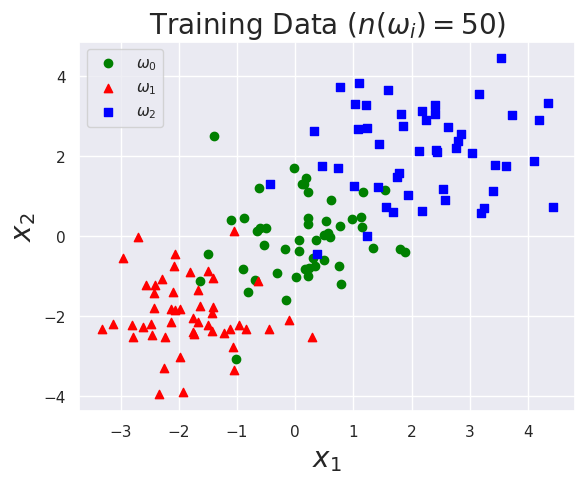

In [8]:
samples = true_distribution.create_samples(50)
plot_samples(samples)
plt.savefig('../assets/Q7_TD50.png', dpi=200)
plt.show()

## $n = 500$

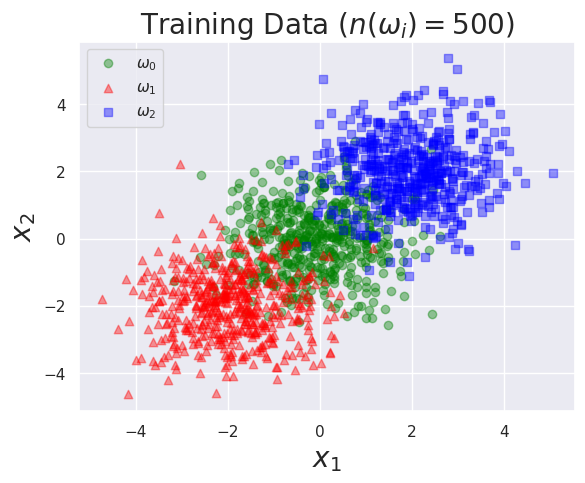

In [10]:
samples = true_distribution.create_samples(500)
plot_samples(samples, alpha=0.4)
plt.savefig('../assets/Q7_TD500.png', dpi=200)
plt.show()

In [11]:
test_data = true_distribution.create_samples(2)
X_test = np.array([test_data[0][0], test_data[0][1], test_data[1][0], test_data[2][0]])
y_test = np.array([0, 0, 1, 2])

In [12]:
cmap_light = ListedColormap(['#85e0e0', '#ff944d', '#b3b3ff'])
cmap_bold = ListedColormap(['#248f8f', '#ff6600', '#000099'])

In [13]:
def print_result(y_true, y_pred):
    print(np.sum(y_pred == y_true), "/", len(y_true), "correct predictions") 

## Decision Boundary

n = 50:
    V_N = 1   : 3 / 4 correct predictions
    V_N = 0.1 : 4 / 4 correct predictions
n = 500:
    V_N = 1   : 3 / 4 correct predictions
    V_N = 0.1 : 3 / 4 correct predictions


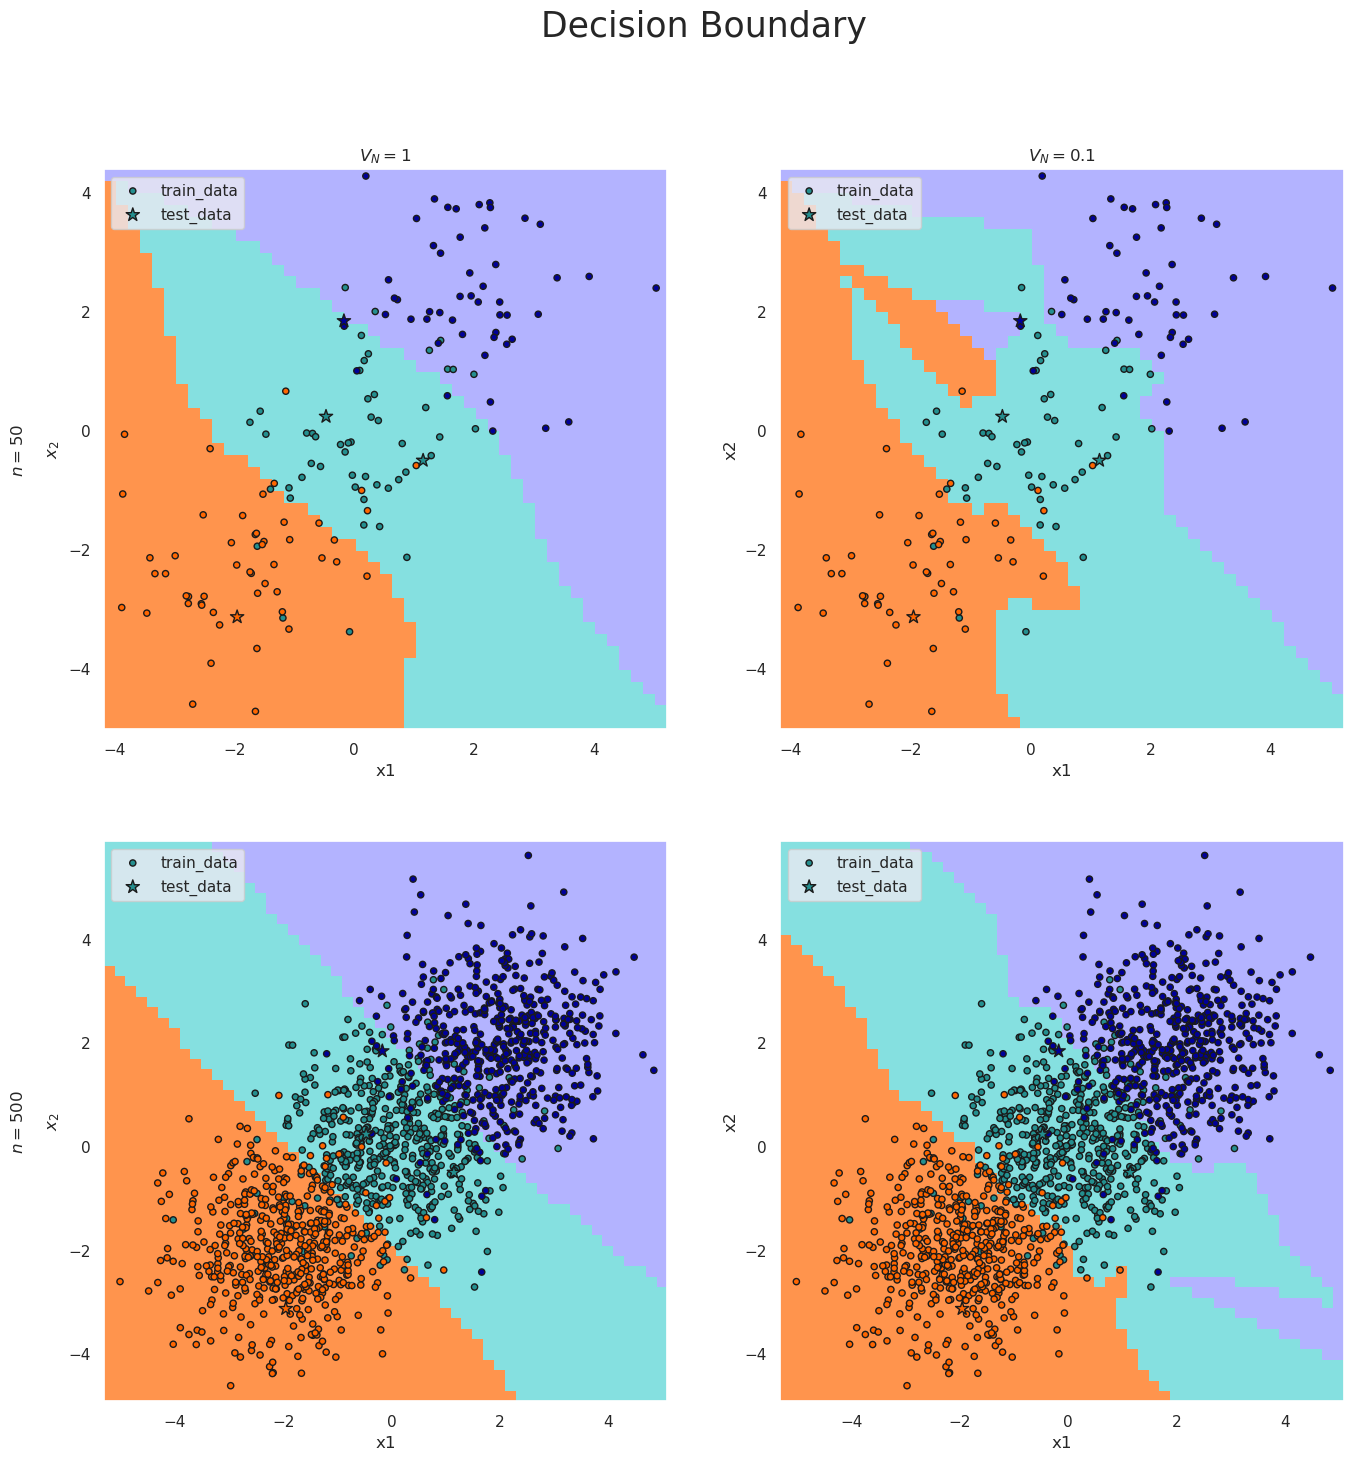

In [15]:
vn_list = [1, 0.1]
num_of_samples = [50, 500]

fig, axs = plt.subplots(2, 2, figsize=(16, 16))

for i in range(len(num_of_samples)):
    print(f"n = {num_of_samples[i]}:")

    samples = true_distribution.create_samples(num_of_samples[i])

    X_train_array = np.array(samples).reshape(-1, 2)
    y_train_array = np.array([np.full(len(samples[i]), i) for i in range(len(samples))]).flatten()

    x1_train_min, x1_train_max = X_train_array[:, 0].min() - 0.2, X_train_array[:, 0].max() + 0.2
    x2_train_min, x2_train_max = X_train_array[:, 1].min() - 0.2, X_train_array[:, 1].max() + 0.2

    xx, yy = np.meshgrid(np.arange(x1_train_min, x1_train_max, 0.2),
                         np.arange(x2_train_min, x2_train_max, 0.2))

    for j in range(len(vn_list)):
        print(f"    V_N = {vn_list[j]: <4}:", end=" ")

        likelihoods = [Parzen(sample, SphericalGaussian().pdf, np.sqrt(vn_list[j])).estimated_pdf for sample in samples]
        priors = np.ones(true_distribution.num_of_classes) / true_distribution.num_of_classes
        model = BayesClassifier(likelihoods, priors)

        Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        y_pred = model.predict(X_test)
        print_result(y_test, y_pred)
        
        axs[i, j].pcolormesh(xx, yy, Z, cmap=cmap_light)
        axs[i, j].scatter(X_train_array[:, 0], X_train_array[:, 1], c=y_train_array, cmap=cmap_bold, edgecolor='k', s=20, label='train_data')
        axs[i, j].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, marker='*',edgecolor='k', s=100, label='test_data')
        axs[i, j].set(xlabel='x1', ylabel='x2')
        axs[i, j].legend(loc='upper left')

        if j == 0:
            axs[i, j].set_ylabel('$n = $' + str(num_of_samples[i]) + "\n\n" + "$x_2$")
        if i == 0:
            axs[i, j].set_title("$V_N = $" + str(vn_list[j]))
            
fig.suptitle('Decision Boundary', fontsize=25)
plt.savefig('../assets/Q7_DB.png', dpi=300)
plt.show()
